# AIAB Paper 3

# The Task

Write a report that examines the evolution of behavior on the cart pole task (or any other task). Successfully optimise the controller to achieve greater than 95% accuracy on the cart pole task model provided in the worksheet. You can use a GA, or a population of hillclimbers, or any other algorithm you wish to construct (but don't use an optimization package). 

  - Minimal required  technical achievements:
    - Demonstrate that the controller is evolving with a plot of best fitness versus tournaments for several runs of your algorithm. 
    - Demonstrate with plots the behavior of the successful controller, e.g., plot angle versus time, angular velocity versus time, or provide a link to a video.
    - Show examples of the best controller after 0 tournaments, half way through the run,  and at the end of optimization, and describe what changes in the behavior. 

  - You might consider choosing behaviors associated with jumps in fitness (GA’s often exhibit plateaus and then sudden jumps).

# Solving The Task

## Setting up methods


In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym-notebook-wrapper
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
import random
import copy
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

import gnwrapper
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
import numpy as np
import torch

import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from google.colab import files

!mkdir figs

In [ ]:
def run_episode(env, agent):
    tot_reward = 0.0
    obs = env.reset()
    done = False
    while not done:
        action = agent.get_action(obs)
        obs, reward, done, info = env.step(action)
        tot_reward = tot_reward + reward
    return tot_reward

In [ ]:
class Agent:
    def __init__(self, num_input, num_output):
        self.num_input = num_input 
        self.num_output = num_output
        self.num_genes = num_input * num_output + num_output
        self.weights = None
        self.bias = None

    def set_genes(self, gene):
        weight_idxs = self.num_input * self.num_output
        bias_idxs = self.num_input * self.num_output + self.num_output
        w = gene[0 : weight_idxs].reshape(self.num_output, self.num_input)   
        b = gene[weight_idxs: bias_idxs].reshape(self.num_output,)
        self.weights = torch.from_numpy(w)
        self.bias = torch.from_numpy(b)

    def forward(self, x):
        x = torch.from_numpy(x).unsqueeze(0)
        return torch.mm(x, self.weights.T) + self.bias

    def get_action(self, x):
        if self.forward(x) > 0:
            return 1
        else:
            return 0

In [ ]:
def fitness_function(env, agent, gene, check_count=7):
    agent.set_genes(gene)
    fitness = np.array([run_episode(env, agent) for i in range(check_count)]).sum() / check_count
    return fitness

In [ ]:
def mutation_function(gene, mean=0, std=0.1):
    g = gene.copy()
    g = gene + np.random.normal(mean, std, size=gene.shape)

    g[g > 4] = 4
    g[g < -4] = -4

    return g

In [ ]:
def crossover_function(gene_one, gene_two, crossover=0.01):
  for i, n in enumerate(gene_one):
    if np.random.rand() < crossover:
      gene_two[i] = n
  
  return gene_two

In [ ]:
def demes_tourney_select(pop_size, fitnesses, window=3):
  contestant_one = np.random.choice(range(pop_size))
  contestant_two = (contestant_one + np.random.choice(range(1, window + 1))) % pop_size 
  return [contestant_one, contestant_two] if fitnesses[contestant_one] >= fitnesses[contestant_two] else [contestant_two, contestant_one]

In [ ]:
def get_best_gene(gene_pop, fitness):
    return gene_pop[np.argmax(fitness)]

In [ ]:
def get_population_fitness(genos, pop_size):
  fitnesses = np.empty(pop_size)
  for i, g in enumerate(genos):
    fitnesses[i] = fitness_function(env, agent, g)
  
  return fitnesses

In [ ]:
def visualise(genos, current_fitnesses):
  best_gene = get_best_gene(genos, current_fitnesses)
  agent.set_genes(best_gene)

  arr = [[], [], [], []]

  env = gnwrapper.Monitor(gym.make(env_name))
  observation = env.reset()

  total_award = 0

  while True:
      action = agent.get_action(observation)
      observation, reward, done, info = env.step(action) 

      for i in range(4):
        arr[i].append(observation[i])

      env.render()

      total_award += reward

      if done: 
        break
            
  print('Fitness:', total_award)
  env.display()

  return arr

## Enviroment

In [ ]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

print(f"Action space {env.action_space} \nObservation space {env.observation_space}")

Action space Discrete(2) 
Observation space Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


In [ ]:
num_obs, num_actions = 4, 1 
agent = Agent(num_obs, num_actions)
epochs, pop_size, window, crossover, mutation_std = 125, 25, 3, 0.05, 0.05

## Full Microbial GA

In [ ]:
geno_fitnesses = np.zeros((pop_size, epochs))
genos = np.random.normal(0, 0.1, (pop_size, agent.num_genes))
current_fitnesses = get_population_fitness(genos, pop_size)

for epoch in trange(epochs):
  for gene in range(pop_size):
    winner_id, loser_id = demes_tourney_select(pop_size, current_fitnesses, window=window)

    crossover_loser = crossover_function(genos[winner_id].copy(), genos[loser_id].copy(), crossover=crossover)
    mutated_loser = mutation_function(crossover_loser, std=mutation_std)

    genos[loser_id] = mutated_loser
    current_fitnesses[loser_id] = fitness_function(env, agent, mutated_loser)

  geno_fitnesses[:, epoch] = current_fitnesses

### Simple Plots

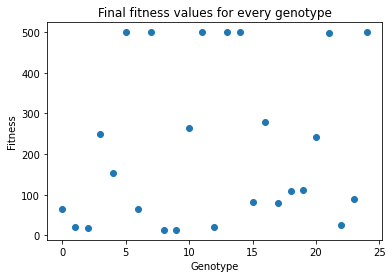

In [ ]:
plt.scatter(range(0, pop_size), current_fitnesses)
plt.title("Final fitness values for every genotype")
plt.xlabel('Genotype')
plt.ylabel('Fitness')
plt.savefig('figs/final-fitness-geneotype.png', pad_inches=0.1, bbox_inches='tight')

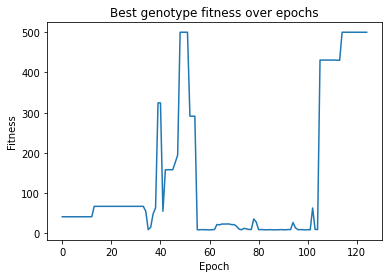

In [ ]:
plt.plot(range(0, epochs), geno_fitnesses[np.argmax(current_fitnesses)])
plt.title("Best genotype fitness over epochs")
plt.xlabel('Epoch')
plt.ylabel('Fitness')
plt.savefig('figs/best-evolution-geneotype-single.png', pad_inches=0.1, bbox_inches='tight')

## Testing the model

In [ ]:
visualise(genos, current_fitnesses)
print('Done!')

Fitness: 500.0


'openaigym.video.0.71.video000000.mp4'

Done!


# Statistics
Write a report that examines the evolution of behavior on the cart pole task (or any other task). Successfully optimise the controller to achieve greater than 95% accuracy on the cart pole task model provided in the worksheet. You can use a GA, or a population of hillclimbers, or any other algorithm you wish to construct (but don't use an optimization package). 

  - Minimal required  technical achievements:
    - Demonstrate that the controller is evolving with a plot of best fitness versus tournaments for several runs of your algorithm. 
    - Demonstrate with plots the behavior of the successful controller, e.g., plot angle versus time, angular velocity versus time, or provide a link to a video.
    - Show examples of the best controller after 0 tournaments, half way through the run,  and at the end of optimization, and describe what changes in the behavior. 

  - You might consider choosing behaviors associated with jumps in fitness (GA’s often exhibit plateaus and then sudden jumps).

In [ ]:
n = 5

In [ ]:
fitness_arr = [[] for i in range(n)]
visualise_arr = []

for i in trange(n):
  geno_fitnesses = np.zeros((pop_size, epochs))
  genos = np.random.normal(0, 0.1, (pop_size, agent.num_genes))
  current_fitnesses = get_population_fitness(genos, pop_size)

  for epoch in trange(epochs):
    for gene in range(pop_size):
      winner_id, loser_id = demes_tourney_select(pop_size, current_fitnesses, window=window)

      crossover_loser = crossover_function(genos[winner_id].copy(), genos[loser_id].copy(), crossover=crossover)
      mutated_loser = mutation_function(crossover_loser, std=mutation_std)

      genos[loser_id] = mutated_loser
      current_fitnesses[loser_id] = fitness_function(env, agent, mutated_loser)

      fitness_arr[i].append(current_fitnesses[np.argmax(current_fitnesses)])

    geno_fitnesses[:, epoch] = current_fitnesses
  
  visualise_arr.append(visualise(genos, current_fitnesses))


Fitness: 500.0


'openaigym.video.1.71.video000000.mp4'


Fitness: 500.0


'openaigym.video.2.71.video000000.mp4'


Fitness: 500.0


'openaigym.video.3.71.video000000.mp4'


Fitness: 500.0


'openaigym.video.4.71.video000000.mp4'


Fitness: 500.0


'openaigym.video.5.71.video000000.mp4'

- Demonstrate that the controller is evolving with a plot of best fitness versus tournaments for several runs of your algorithm. 

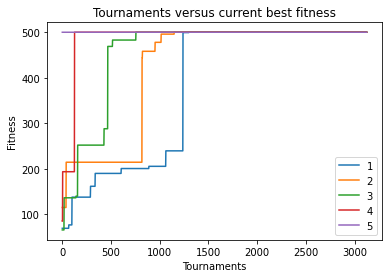

In [ ]:
for i in range(n):
  plt.plot(range(epochs * pop_size), fitness_arr[i], label=i+1)
plt.title('Tournaments versus current best fitness')
plt.xlabel('Tournaments')
plt.ylabel('Fitness')
plt.legend()
plt.savefig('figs/seperate-torney', pad_inches=0.1, bbox_inches='tight')

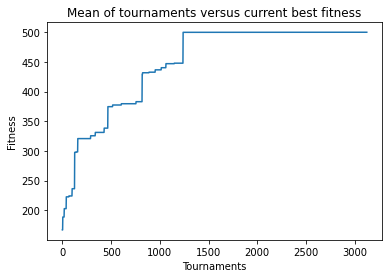

In [ ]:
new_arr = np.array(fitness_arr).mean(axis=0)

plt.plot(range(epochs * pop_size), new_arr)
plt.title('Mean of tournaments versus current best fitness')
plt.xlabel('Tournaments')
plt.ylabel('Fitness')
plt.savefig('figs/mean-torney', pad_inches=0.1, bbox_inches='tight')

- Demonstrate with plots the behavior of the successful controller, e.g., plot angle versus time, angular velocity versus time, or provide a link to a video.

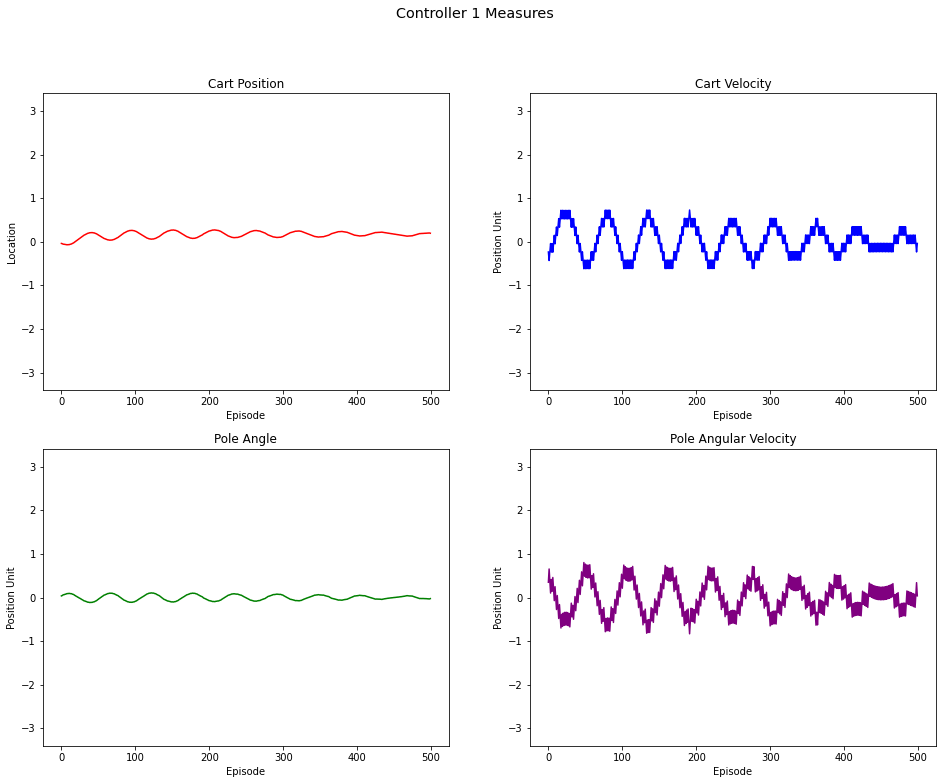

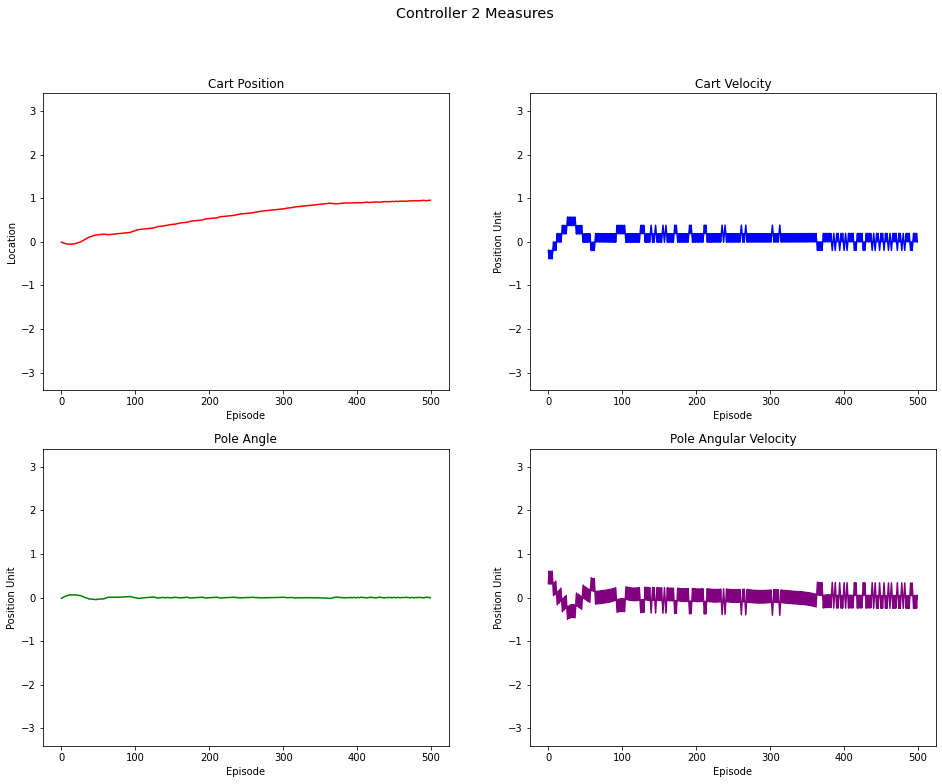

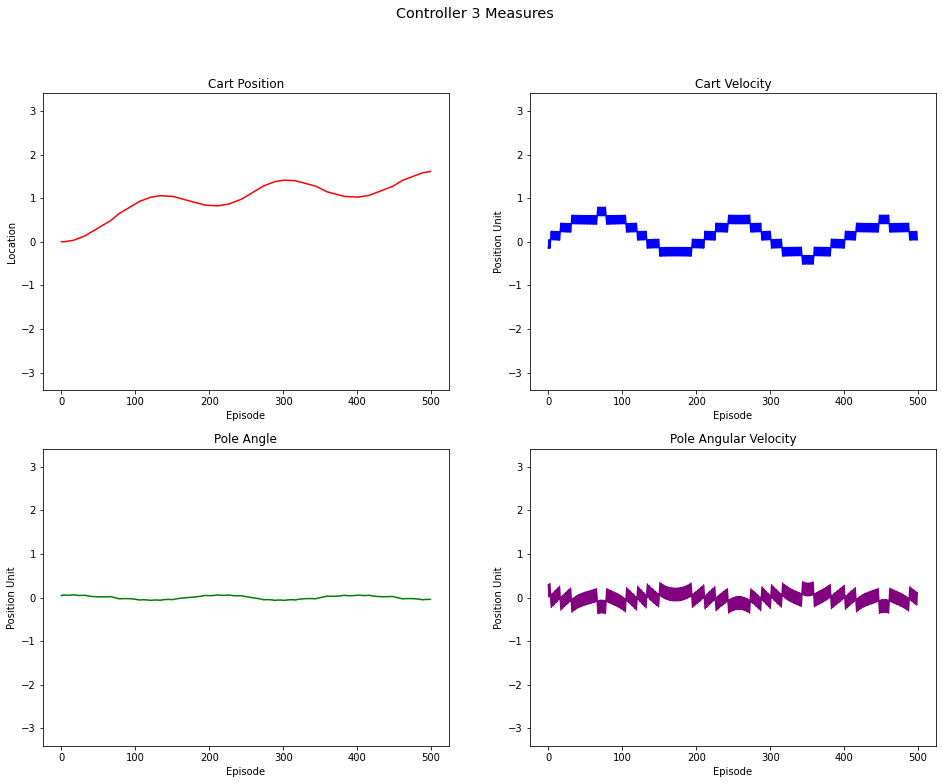

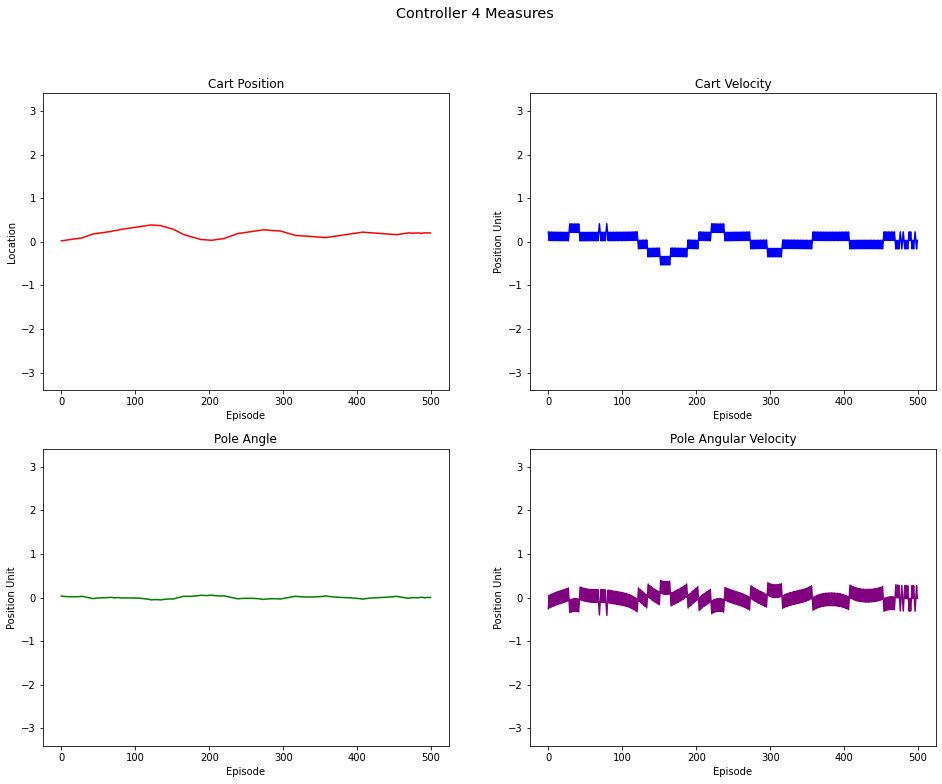

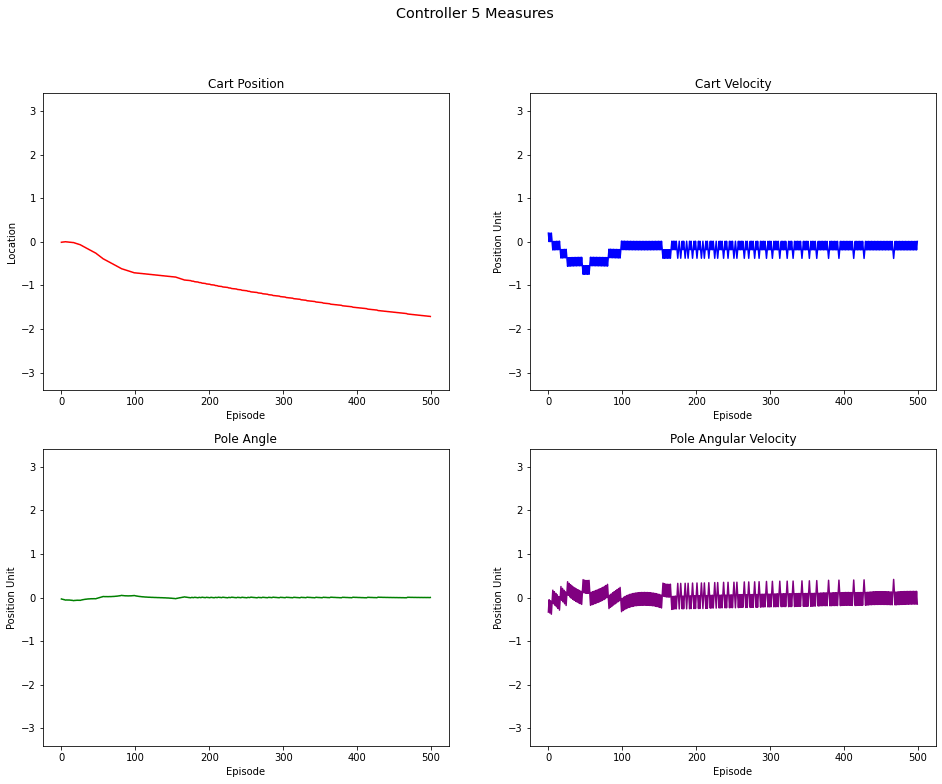

In [ ]:
for i in range(n):
  fig, axs = plt.subplots(2, 2, figsize=(16, 12))

  st = fig.suptitle("Controller %s Measures" % (i+1), fontsize="x-large")

  axs[0,0].plot(visualise_arr[i][0], color='red')
  axs[0,1].plot(visualise_arr[i][1], color='blue')
  axs[1,0].plot(visualise_arr[i][2], color='green')
  axs[1,1].plot(visualise_arr[i][3], color='purple')

  axs[0,0].set_ylim(-3.4, 3.4)
  axs[0,1].set_ylim(-3.4, 3.4)
  axs[1,0].set_ylim(-3.4, 3.4)
  axs[1,1].set_ylim(-3.4, 3.4)

  axs[0,0].set_title('Cart Position')
  axs[0,1].set_title('Cart Velocity')
  axs[1,0].set_title('Pole Angle')
  axs[1,1].set_title('Pole Angular Velocity')

  for ax in axs.flat:
    ax.set(xlabel='Episode', ylabel='Position Unit')

  axs[0,0].set(ylabel='Location')

  plt.savefig('figs/fig-cart-%s.png' % (i+1), pad_inches=0.1, bbox_inches='tight')
  plt.show()
  print()

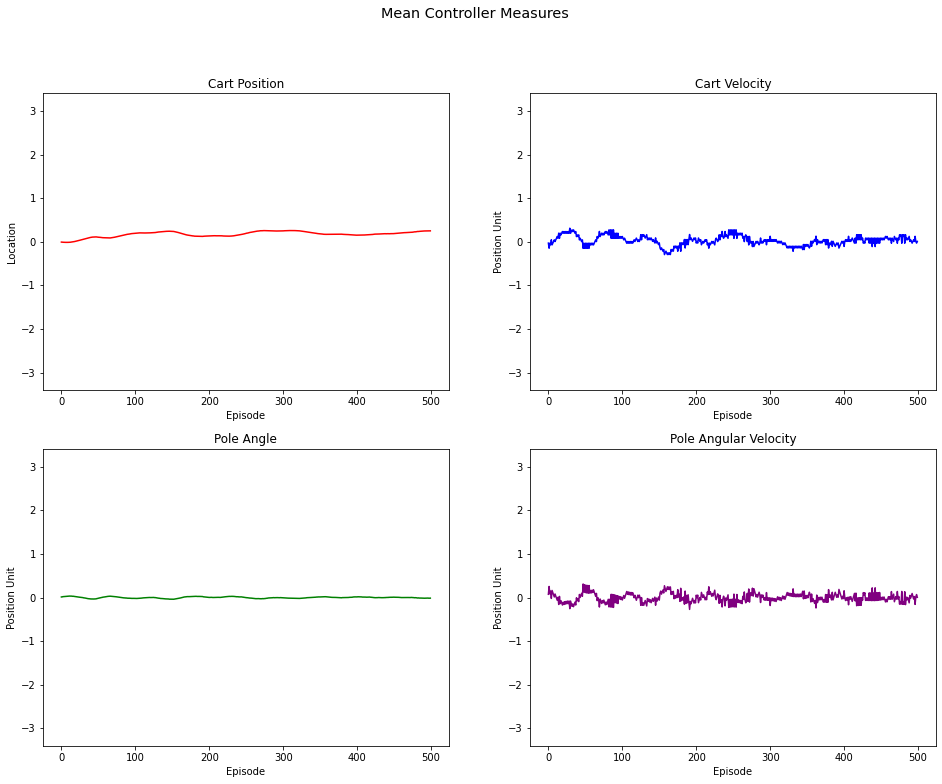

In [ ]:
new_arr = np.array(visualise_arr).mean(axis=0)
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

st = fig.suptitle("Mean Controller Measures", fontsize="x-large")

axs[0,0].plot(new_arr[0], color='red')
axs[0,1].plot(new_arr[1], color='blue')
axs[1,0].plot(new_arr[2], color='green')
axs[1,1].plot(new_arr[3], color='purple')

axs[0,0].set_ylim(-3.4, 3.4)
axs[0,1].set_ylim(-3.4, 3.4)
axs[1,0].set_ylim(-3.4, 3.4)
axs[1,1].set_ylim(-3.4, 3.4)

axs[0,0].set_title('Cart Position')
axs[0,1].set_title('Cart Velocity')
axs[1,0].set_title('Pole Angle')
axs[1,1].set_title('Pole Angular Velocity')

for ax in axs.flat:
  ax.set(xlabel='Episode', ylabel='Position Unit')

axs[0,0].set(ylabel='Location')

plt.savefig('figs/cart-mean.png', pad_inches=0.1, bbox_inches='tight')

- Show examples of the best controller after 0 tournaments, half way through the run, and at the end of optimization, and describe what changes in the behavior. 

In [ ]:
progress = [[], [], []]

geno_fitnesses = np.zeros((pop_size, epochs))
genos = np.random.normal(0, 0.1, (pop_size, agent.num_genes))
current_fitnesses = get_population_fitness(genos, pop_size)

progress[0] = visualise(genos, current_fitnesses)

for epoch in trange(epochs):
  for gene in range(pop_size):
    winner_id, loser_id = demes_tourney_select(pop_size, current_fitnesses, window=window)

    crossover_loser = crossover_function(genos[winner_id].copy(), genos[loser_id].copy(), crossover=crossover)
    mutated_loser = mutation_function(crossover_loser, std=mutation_std)

    genos[loser_id] = mutated_loser
    current_fitnesses[loser_id] = fitness_function(env, agent, mutated_loser)

    fitness_arr[i].append(current_fitnesses[np.argmax(current_fitnesses)])

  if epoch == 62:
    progress[1] = visualise(genos, current_fitnesses)

  geno_fitnesses[:, epoch] = current_fitnesses

progress[2] = visualise(genos, current_fitnesses)

Fitness: 25.0


'openaigym.video.19.71.video000000.mp4'

Fitness: 462.0


'openaigym.video.20.71.video000000.mp4'


Fitness: 500.0


'openaigym.video.21.71.video000000.mp4'

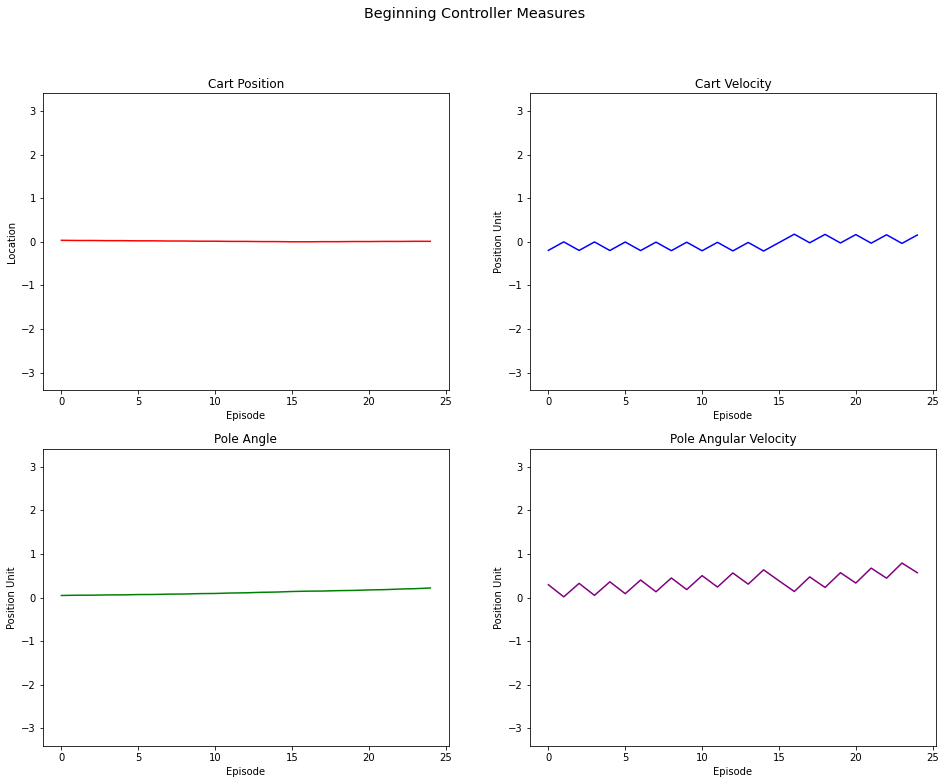

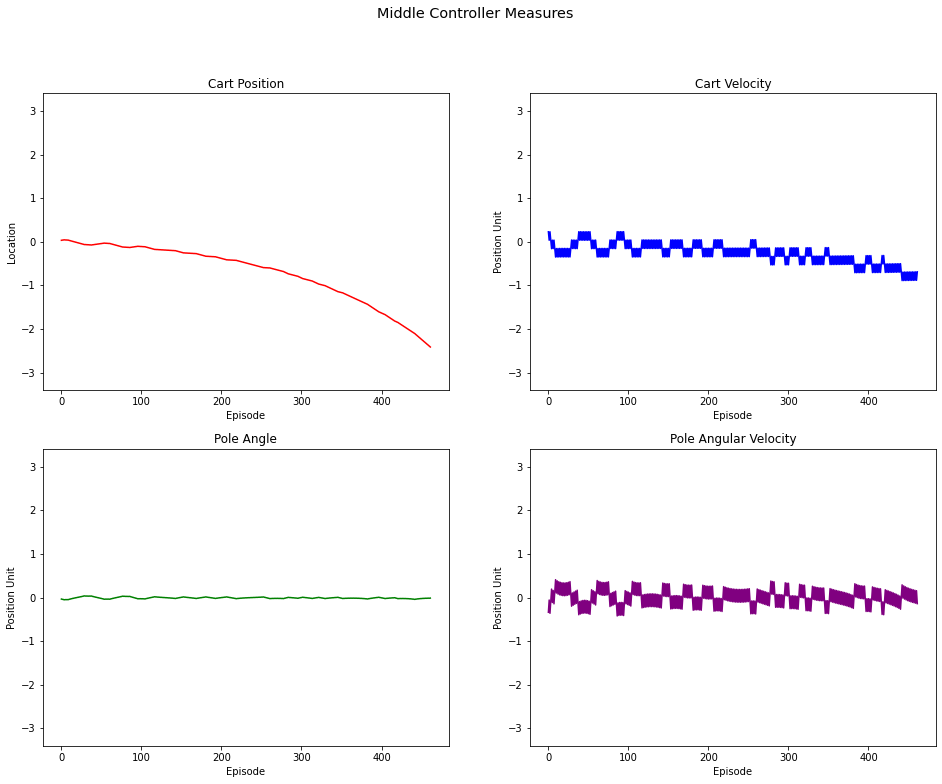

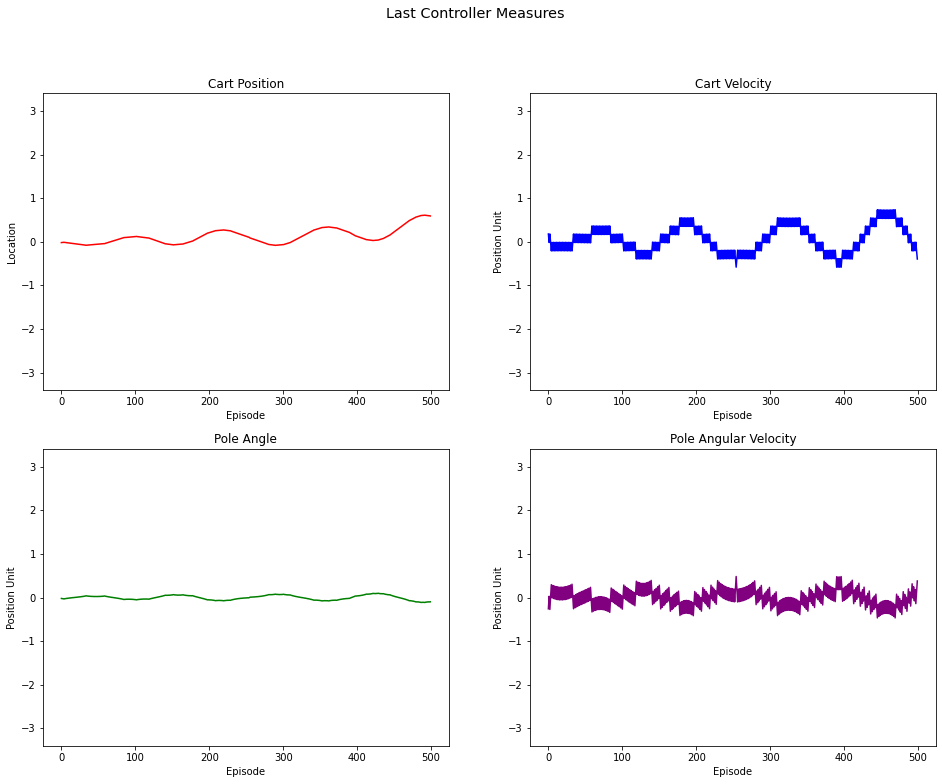

In [ ]:
for i, title in enumerate(['Beginning', 'Middle', 'Last']):
  fig, axs = plt.subplots(2, 2, figsize=(16, 12))

  st = fig.suptitle("%s Controller Measures" % (title), fontsize="x-large")

  axs[0,0].plot(progress[i][0], color='red')
  axs[0,1].plot(progress[i][1], color='blue')
  axs[1,0].plot(progress[i][2], color='green')
  axs[1,1].plot(progress[i][3], color='purple')

  axs[0,0].set_ylim(-3.4, 3.4)
  axs[0,1].set_ylim(-3.4, 3.4)
  axs[1,0].set_ylim(-3.4, 3.4)
  axs[1,1].set_ylim(-3.4, 3.4)

  axs[0,0].set_title('Cart Position')
  axs[0,1].set_title('Cart Velocity')
  axs[1,0].set_title('Pole Angle')
  axs[1,1].set_title('Pole Angular Velocity')

  for ax in axs.flat:
    ax.set(xlabel='Episode', ylabel='Position Unit')

  axs[0,0].set(ylabel='Location')

  plt.savefig('figs/fig-evolve-%s.png' % (title), pad_inches=0.1, bbox_inches='tight')
  plt.show()
  print()

In [ ]:
!rm -rf sample_data
!rm -rf paper-3-files.zip
!zip -r /content/paper-3-files.zip /content
files.download("/content/paper-3-files.zip")

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2021.05.06/ (stored 0%)
  adding: content/.config/logs/2021.05.06/13.44.00.991142.log (deflated 54%)
  adding: content/.config/logs/2021.05.06/13.43.44.620859.log (deflated 53%)
  adding: content/.config/logs/2021.05.06/13.43.04.692209.log (deflated 91%)
  adding: content/.config/logs/2021.05.06/13.44.01.543195.log (deflated 53%)
  adding: content/.config/logs/2021.05.06/13.43.23.909017.log (deflated 54%)
  adding: content/.config/logs/2021.05.06/13.43.39.026092.log (deflated 86%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 23%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configuration

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>